In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="talk")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import nn, optimizers, losses
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.callbacks import EarlyStopping

## Import Dataset

In [2]:
df = (pd.read_csv("/content/BRITANNIA.csv", date_parser="Date").loc[:, ["Date", "Open"]])

In [3]:
df.isna().sum()

Date    0
Open    0
dtype: int64

In [4]:
df.dropna(axis="rows", how="any", inplace=True)

In [5]:
df.isna().sum()

Date    0
Open    0
dtype: int64

In [6]:
df.shape

(5305, 2)

## Ubah kolom ke array

In [68]:
tanggal = df["Date"].values
open_price = df["Open"].values
open_price = open_price.reshape((len(open_price), 1))
scaller = MinMaxScaler()
scaller = scaller.fit(open_price)
normalized_price = scaller.transform(open_price)
normalized_price = normalized_price.reshape(1, len(normalized_price))
normalized_price = normalized_price[0]

In [69]:
normalized_price

array([0.05548799, 0.0562481 , 0.06308908, ..., 0.47856491, 0.4798951 ,
       0.4743083 ])

## Plotting

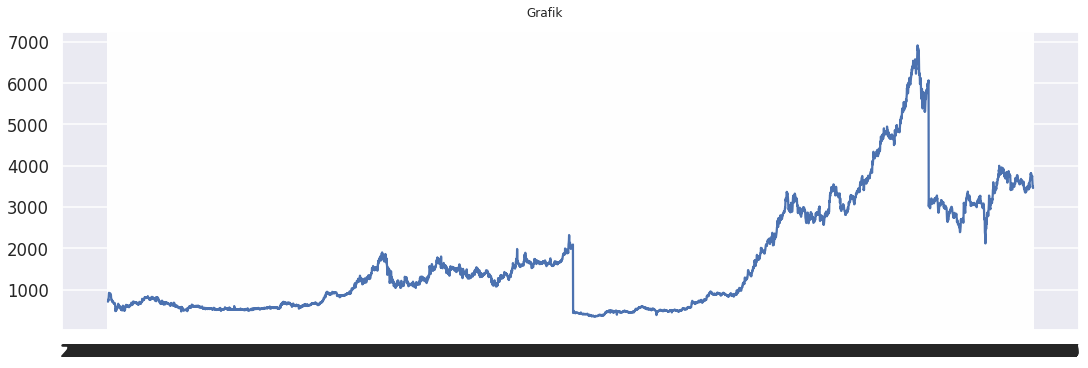

In [8]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(15, 5))
fig.suptitle("Grafik")
_ = plt.plot(tanggal, open_price)
plt.show()

## Function

In [70]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

## Dataset Splitting

In [71]:
X_train, X_test, y_train, y_test = train_test_split(tanggal, normalized_price, test_size=0.2, shuffle=False, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4244,), (1061,), (4244,), (1061,))

## Buat train_set dan val_set

In [72]:
train_set = windowed_dataset(y_train, window_size=64, batch_size=64, shuffle_buffer=1000)
val_set = windowed_dataset(y_test, window_size=64, batch_size=64, shuffle_buffer=1000)

## Arsitektur Model

In [73]:
model = tf.keras.models.Sequential([
  LSTM(64, return_sequences=True),
  LSTM(64),
  Dense(256, activation="relu"),
  Dropout(0.4),
  Dense(128, activation="relu"),
  Dense(128, activation="relu"),
  Dense(1),
])

## Compile

In [74]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0003), loss=losses.Huber(), metrics=["mae"])

## Training


In [75]:
es = EarlyStopping(monitor="val_mae", mode="min", patience=25, verbose=1, restore_best_weights=True)

In [76]:
hist = model.fit(train_set,epochs=1000, workers=-1, batch_size=64, validation_data=val_set, verbose=1, callbacks=[es])

Epoch 1/1000
66/66 [==============================] - 10s 102ms/step - loss: 4.2290e-04 - mae: 0.0209 - val_loss: 0.0024 - val_mae: 0.0566
Epoch 2/1000
66/66 [==============================] - 6s 93ms/step - loss: 1.6777e-04 - mae: 0.0111 - val_loss: 0.0019 - val_mae: 0.0473
Epoch 3/1000
66/66 [==============================] - 6s 93ms/step - loss: 1.4166e-04 - mae: 0.0100 - val_loss: 0.0029 - val_mae: 0.0652
Epoch 4/1000
66/66 [==============================] - 6s 91ms/step - loss: 1.5725e-04 - mae: 0.0114 - val_loss: 0.0023 - val_mae: 0.0559
Epoch 5/1000
66/66 [==============================] - 6s 91ms/step - loss: 1.2914e-04 - mae: 0.0097 - val_loss: 0.0030 - val_mae: 0.0674
Epoch 6/1000
66/66 [==============================] - 6s 92ms/step - loss: 1.2281e-04 - mae: 0.0095 - val_loss: 0.0035 - val_mae: 0.0750
Epoch 7/1000
66/66 [==============================] - 6s 90ms/step - loss: 1.2120e-04 - mae: 0.0093 - val_loss: 0.0022 - val_mae: 0.0572
Epoch 8/1000
66/66 [===================

## Hasil MAE
Data Train

In [77]:
model.evaluate(train_set, batch_size=128, workers=-1, verbose=1)

66/66 [==============================] - 2s 29ms/step - loss: 9.9780e-05 - mae: 0.0072


[9.977957961382344e-05, 0.00723491795361042]

Data Test

In [78]:
model.evaluate(val_set, batch_size=128, workers=-1, verbose=1)

16/16 [==============================] - 1s 28ms/step - loss: 0.0019 - mae: 0.0473


[0.0018963379552587867, 0.047324180603027344]

Dataset sudah saya normalisasi menjadi 0 - 1. hasil mae sudah kurang dari 10% (<0.1)

## Plotting

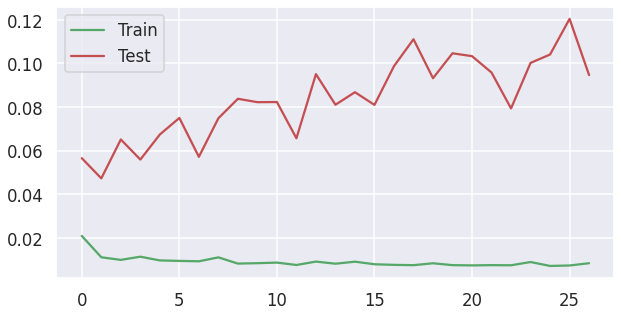

In [79]:
fig, ax = plt.subplots(figsize=(10, 5))
_ = plt.plot(hist.history["mae"], color="g", label="Train")
_ = plt.plot(hist.history["val_mae"], color="r", label="Test")
_ = ax.legend()
plt.show()